### Libraries

In [24]:
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import shapely.geometry as geom
import numpy as np
import pandas as pd
import geopandas as gpd
import math
import time
from collections import namedtuple
from scipy import ndimage
import pickle

%matplotlib inline
plt.rcParams["figure.figsize"] = (20,7)

### Sources

In [25]:
# https://stackoverflow.com/questions/30740046/calculate-distance-to-nearest-feature-with-geopandas
# https://geohackweek.github.io/vector/04-geopandas-intro/
# https://stackoverflow.com/questions/38882233/geopandas-matplotlib-plot-custom-colors

### Notes to myself

In [26]:
# for each discretized square (i.e. current position)
# draw cirle centered in the current square
# place 180 (user-definable parameter) evenly spaced points on the circumference
# define a line segmet between current position and each point on the circumference
# find points of intersection of the line segment with: polygons or the walls of the arena
# take the nearest point
# measure the distance between the nearest point point of intersection and the current position
# this should be distance which the sonar and the IR should be measuring (adjusted for noise)

## Parameters

In [34]:
# Define the arena using the upper-case parameters below

# The origin of the arena, (0,0) is in the lower left corner 
# All parameters are in meters 

W = 4.25
H = 3.2 # 3.2 was given by the tutors but not correct

# Cutoff values in meters beyond which we're cannot confidently measure sensors' readings
CUTOFF = {
    "sonar" : 0.9,
    "IR" : 0.7,    
}

RESOLUTION_POS = 0.1  # write 20 cm as 0.2
RESOLUTION_ROT = 30    # write 6 if you want to measure at increments of 6 degrees (60 measurements total)

# Location of the docking station
BASE = [(3.63,1.55), (4.05,1.55), (3.63,1.25), (4.05,1.25)]

HIGHWAYS = {
    "top1" : [],
    "top2" : []  
}

# Each obstacle is represented as a polygon defined by its vertices (x,y)
OBSTACLES = {
	"triangle_low_left" : ((0,0), (0.6,0), (0,0.7)),
	"triangle_up_right" : ((3.8,3.2), (4.25,3.2), (4.25,2.75)),
	"triangle_center" : ((1.1,1), (1.9,1), (1.475,1.65)),
	"long_rectangle" : ((1.05,2.45),(3.2,2.45),(3.2,2.29),(1.05,2.29)),
	"low_right_square" : ((3.2,1.05), (4.25,1.05), (4.25,0), (3.2,0))
}

WALLS = {
	"bottom" : ((0,0),(W,0)),
	"right" : ((W,0), (W,H)),
	"top" : ((W,H), (0,H)),
	"left" : ((0,H), (0,0))
}

GROUND = ((0,0),(W,0),(W,H),(0,H),(0,0))

NUM_POSES = 0 # Number of poses; will be generated later

## Variables

In [35]:
poses = pd.DataFrame(columns=['open', 'x', 'y', 'theta', 'sonar', 'IR_L', 'IR_R'])


arena_d = pd.DataFrame(columns=['type', 'geometry']) # DataFrame
arena_g = gpd.GeoDataFrame(arena_d) #Geo DataFrame

### Draw arena

       type                                           geometry
0  obstacle                 POLYGON ((0 0, 0.6 0, 0 0.7, 0 0))
1  obstacle  POLYGON ((3.8 3.2, 4.25 3.2, 4.25 2.75, 3.8 3.2))
2  obstacle        POLYGON ((1.1 1, 1.9 1, 1.475 1.65, 1.1 1))
3  obstacle  POLYGON ((1.05 2.45, 3.2 2.45, 3.2 2.29, 1.05 ...
4  obstacle  POLYGON ((3.2 1.05, 4.25 1.05, 4.25 0, 3.2 0, ...
5      wall                           LINESTRING (0 0, 4.25 0)
6      wall                      LINESTRING (4.25 0, 4.25 3.2)
7      wall                       LINESTRING (4.25 3.2, 0 3.2)
8      wall                            LINESTRING (0 3.2, 0 0)


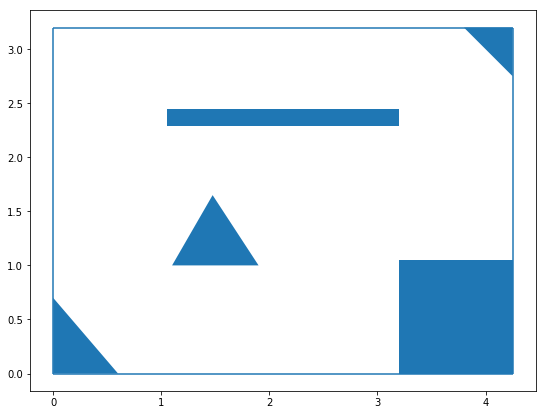

In [36]:
# Obstacles
for polygon in OBSTACLES:
    arena_d.loc[len(arena_d)] = ["obstacle", geom.Polygon(OBSTACLES[polygon])]

# Walls
for wall in WALLS:
    arena_d.loc[len(arena_d)] = ["wall", geom.LineString(WALLS[wall])]

print(arena_d)

arena_g = gpd.GeoDataFrame(arena_d)
arena_g.plot()

### Run 360° distance scan

Record the distance to nearest obstacle from each discretized square
Resolution is defined by the RESOLUTION_ROT parameter

In [ ]:
num_squares = 0

def emptySpace(position):
    """
    Returns True if a given does NOT overlap with the coordinates of an obstacle.
    """
    # iterate over obstacles
    for obj in arena_g.loc[arena_g['type'] == 'obstacle', 'geometry']:
        # if square doesn't intersect with an obstacle
        if obj.intersects(position):
            return False
    return True

def distanceToNearestObstacles(position, p):
    """
    Returns the distance to the nearest obstacle in meters. 
    """
    laser = geom.LineString((position, p))
    
    nearest = float("inf")
    for obj in arena_g.loc[arena_g['type'].isin(['obstacle', 'wall']), 'geometry']:
        # find intersections of the laser line segment with obstacles and walls
        intersection =  np.array(laser.intersection(obj))
        if intersection.shape == (2, 2): # if intersecting a polygon
            for i in intersection:
                distance = geom.Point(i).distance(position)
                if distance < nearest:
                    nearest = distance
        elif intersection.shape == (2,): # if intersecting another line
            distance = geom.Point(intersection).distance(position)
            if distance < nearest:
                nearest = distance
    return nearest
    dist_array.append(nearest)
    
    
def PointsInCircum(x=0, y=0, r=6):
        """
        x, y    :: coordinates of center of circle
        r       :: circle radius
        returns :: CLOCKWISE n coordinates of points which lie on the
                   circumference of a circle centered at (x,y)

        """
        # desired num of number of points on the circumference of the circle
        n = round(360 / RESOLUTION_ROT)
        return [(math.sin(2*math.pi/n*i)*r + x, math.cos(2*math.pi/n*i)*r + y) for i in range(0,n)]
    
def scan360(position):
    measurements = list()
    
    for p in PointsInCircum(x=position.x, y=position.y):
        measurements.append(distanceToNearestObstacles(position, geom.Point(p[0],p[1])))
        
    return measurements


### Generate DataFrame with all discretized poses

In [ ]:
# iterate over the arena (represented as discrete squares)

t1 = time.time()

# drop all rows generated in a previous run of the code
poses.drop(poses.index, inplace=True)

# iterate squares horizontally, along x-axis
for x in np.arange(0.01, W, RESOLUTION_POS):
    # iterate squares vertically
    for y in np.arange(0.01,H,RESOLUTION_POS):
        # we're at the coordinates below
        position = geom.Point(x,y) 
        # if position not a blocked area, e.g. an obstacle
        if emptySpace(position):
            # take measurements around to nearest obstacles at increments of RESOLUTION_ROT
            measurements = scan360(position)
            # for each measurement (i.e. for each pose), determine the true reading for each of our 3 sensors
            for i, val in enumerate(measurements):
                sonar = measurements[int(i % len(measurements))]                
                IR_R = measurements[round(i + 0.25 * len(measurements)) % len(measurements)]
                IR_L = measurements[round(i + 0.75 * len(measurements)) % len(measurements)]
                theta = (i*RESOLUTION_ROT) % 360
                poses.loc[len(poses)] = [1, x, y, theta, sonar, IR_L, IR_R]
                NUM_POSES += 1
        else:
            poses.loc[len(poses)] = [0, x, y, 0, 0, 0, 0]
                
# Initializes prob to a uniform distribution 
# over a grid of the same dimensions as arena
poses['prob'] = pd.Series([0]*len(poses))
poses.loc[poses.open == 1, 'prob'] = 1.0/ NUM_POSES

t2 = time.time()
print('DataFrame generated in ' + str(t2-t1) + ' seconds.')

#### Inspect table – does it look sensible?

In [ ]:
poses.sort_values(['y', 'x', 'theta'], ascending=[False, True, True], inplace=True)

poses[poses["x"].isin([0.01]) & poses['y'].isin([0.81])]
poses[poses['theta'].isin([0])]
poses[poses['sonar'].between(1,1.1) & poses['theta'].isin([0])]
poses[poses['sonar'].between(0.1,0.3) & poses['theta'].isin([90])]

### Save map to disk

In [ ]:
pickle.dump(poses, open("poses.df", 'wb'))
pickle.dump(arena_d, open("arena_d.df", 'wb'))
pickle.dump(arena_g, open("arena_g.gdf", 'wb'))